## RNN model 

                           generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00  

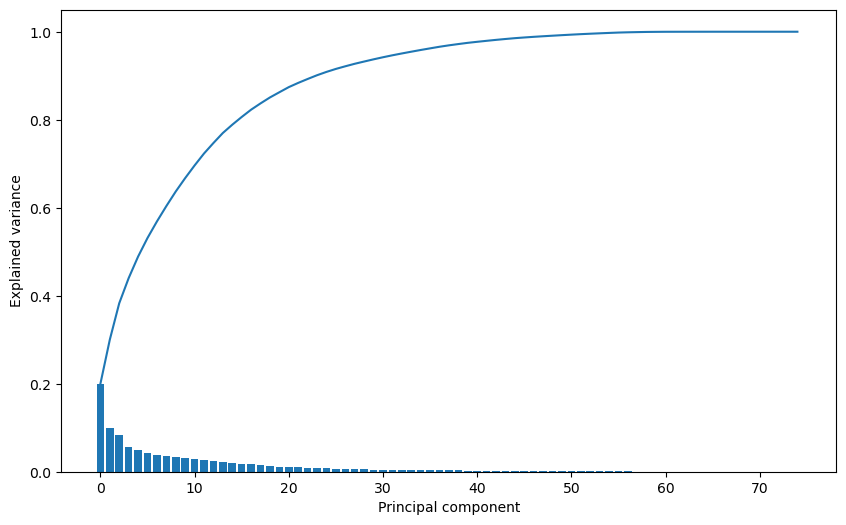

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.layers import Input
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import tensorflow as tf
import keras_tuner as kt
import pickle
from tensorflow.keras.models import load_model
import import_ipynb
from feature_engineering import scaler_y

In [2]:
# Data Import 

# Load X_train
with open("data/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Load y_train
with open("data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Load X_val
with open("data/X_val.pkl", "rb") as f:
    X_val = pickle.load(f)

# Load y_val
with open("data/y_val.pkl", "rb") as f:
    y_val = pickle.load(f)

# Load X_test
with open("data/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Load y_test
with open("data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

# Load df_final_viz
with open("data/df_final_viz.pkl", "rb") as f:
    df_final_viz = pickle.load(f)


In [3]:
batch_size = 32  # consistent batch size for fair comparison

# Create TensorFlow Dataset from training data, including shuffle for better generalization
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(buffer_size=len(X_train)) \
    .batch(batch_size, drop_remainder=False) \
    .prefetch(tf.data.AUTOTUNE)

# Create TensorFlow Dataset from validation data (no shuffle needed, cache for performance)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .cache() \
    .batch(batch_size, drop_remainder=False) \
    .prefetch(tf.data.AUTOTUNE)

# Create TensorFlow Dataset from test data (no shuffle needed, cache for performance)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .cache() \
    .batch(batch_size, drop_remainder=False) \
    .prefetch(tf.data.AUTOTUNE)

In [4]:
for X_batch, y_batch in train_dataset.take(1):
    print(f"Batch shape (X, y): {X_batch.shape}, {y_batch.shape}")

Batch shape (X, y): (32, 24, 17), (32,)


2025-03-25 14:53:14.762764: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    #train_rmse = history.history['root_mean_squared_error']
    #val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    #plt.figure(figsize=(20, 10))
    #plt.subplot(1, 2, 1)
    #plt.plot(train_rmse, label='Training RMSE')
    #plt.plot(val_rmse, label='Validation RMSE')
    #plt.legend()
    #plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [6]:
rnn_model = Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])), 
    SimpleRNN(48),
    Dropout(0.1),
    Dense(56),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.9**epoch)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("rnn_1.keras", monitor= "val_loss", save_best_only=True)

optimizer = tf.keras.optimizers.Adam(amsgrad=True)

rnn_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

#Training using tensorflor dataset 
history = rnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, lr_schedule]
)


#history = rnn_model.fit(X_train, y_train, epochs=50, validation_data = (X_val, y_val), batch_size=32, verbose=1, callbacks = [early_stopping, model_checkpoint, lr_schedule])


Epoch 1/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0615 - root_mean_squared_error: 0.2189 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589 - learning_rate: 0.0010
Epoch 2/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438 - learning_rate: 9.0000e-04
Epoch 3/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432 - learning_rate: 8.1000e-04
Epoch 4/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396 - learning_rate: 7.2900e-04
Epoch 5/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0021 - root_mean_squared_error: 0.0458 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402 - learning_rate: 6.5610e-04
Epoch 6/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0020 - root_

In [7]:
rnn_model = load_model("rnn_1.keras")
predictions = rnn_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse:.4f}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step
RMSE: 0.0288


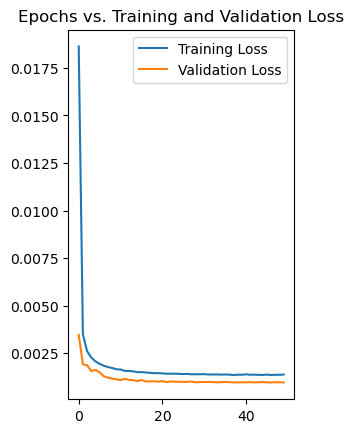

In [8]:
plot_model_rmse_and_loss(history)

In [ ]:
# Function to build rnn-model with hyperparameters
def build_rnn_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2]))) # Separate input shape definition to avoid Keras warning

    #rnn-layer
    model.add(SimpleRNN(
        units=hp.Int('rnn_units', min_value=16, max_value=128, step=16)
    ))

    # Dropout layer for the rnn-layer
    model.add(Dropout(
        rate=hp.Choice('dropout_rate_rnn', [0.1, 0.2, 0.3, 0.4, 0.5])
    ))

    #Second hiddden layer 
    model.add(Dense(
        units=hp.Int('dense_units', min_value=8, max_value=64, step=8),
        activation='relu'
    ))

    # Dropout layer for the second hidden layer
    model.add(Dropout(
        rate=hp.Choice('dropout_rate_dense', [0.0, 0.1, 0.2, 0.3, 0.4])
    ))

    # Output-layer
    model.add(Dense(1))

    ## Using Adam with global weight decay
    optimizer = tf.optimizers.AdamW(
        learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]),
        weight_decay=hp.Choice('weight_decay', [1e-5, 1e-4, 1e-3])
    )

    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    return model

# Keras Tuner for rnn
tuner = kt.Hyperband(
    build_rnn_model,  # Model-building function
    objective='val_loss',  # Objective: minimize validation loss
    max_epochs=15,  # Maximum number of epochs per trial
    factor=3,  # Each successive round reduces the number of trials by this factor
    hyperband_iterations=1,  # Number of Hyperband iterations
    distribution_strategy=tf.distribute.MirroredStrategy(),  # Use multi-GPU if available
    directory='keras_tuner_rnn',  # Directory to store tuning results
    project_name='rnn_hyperband'  # Project name
)

# Execute tuning 
tuner.search(train_dataset, epochs=10, validation_data=val_dataset)




Trial 30 Complete [00h 00m 45s]
val_loss: 0.013612594455480576

Best val_loss So Far: 0.0015451337676495314
Total elapsed time: 00h 07m 32s


In [23]:
#Collect best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best RNN units: {best_hps.get('rnn_units')}")
print(f"Best dense layer units: {best_hps.get('dense_units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best dropout rate (RNN): {best_hps.get('dropout_rate_rnn')}")
print(f"Best dropout rate (dense): {best_hps.get('dropout_rate_dense')}")
print(f"Best global weight decay: {best_hps.get('weight_decay')}")

# Train best model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("rnn_best.keras", monitor= "val_loss", save_best_only=True)
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(train_dataset, epochs=50, validation_data=(val_dataset), verbose = 1, callbacks = [early_stopping, model_checkpoint])


Best RNN units: 48
Best dense layer units: 56
Best learning rate: 0.01
Best dropout rate (RNN): 0.2
Best dropout rate (dense): 0.2
Best global weight decay: 0.001
Epoch 1/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 2/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 3/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 4/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 5/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 7/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 8/50


In [24]:
print(X_train.shape)

(27024, 24, 17)


In [12]:
print(f"Best dropout rate (RNN): {best_hps.get('dropout_rate_rnn')}")
print(f"Best dropout rate (dense): {best_hps.get('dropout_rate_dense')}")

Best dropout rate (RNN): 0.1
Best dropout rate (dense): 0.2


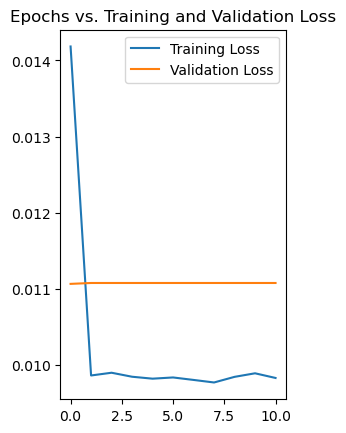

In [25]:
plot_model_rmse_and_loss(history)

In [26]:
rnn_model_best = load_model("rnn_best.keras")
predictions = rnn_model_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse:.4f}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 0.1306


845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step


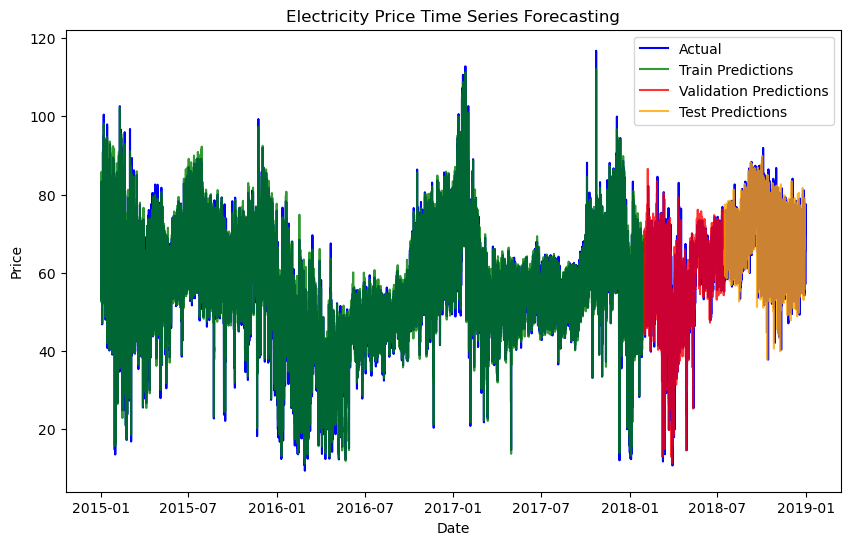

In [15]:
# Make predictions
train_predictions = rnn_model_best.predict(X_train)
validation_predictions = rnn_model_best.predict(X_val)
test_predictions = rnn_model_best.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler_y.inverse_transform(train_predictions)
validation_predictions = scaler_y.inverse_transform(validation_predictions)
test_predictions = scaler_y.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(10, 6))

# Plot actual data
seq_length = 24
plt.plot(df_final_viz.index[seq_length:], df_final_viz['price actual'][seq_length:], label='Actual', color='blue')

# Plot training predictions
plt.plot(df_final_viz.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green', alpha = 0.8)

# Plot validation predictions
validation_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(validation_predictions))
plt.plot(df_final_viz.index[validation_pred_index], validation_predictions, label='Validation Predictions',color='red', alpha = 0.8)

# Plot testing predictions
test_pred_index = range(seq_length+len(train_predictions)+len(validation_predictions), seq_length+len(train_predictions)+len(validation_predictions)+len(test_predictions))
plt.plot(df_final_viz.index[test_pred_index], test_predictions, label='Test Predictions',color='orange', alpha = 0.8)

plt.title('Electricity Price Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
